In [17]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt

In [18]:
np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

In [19]:
with open (X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)
# print(X_train)
# print(Y_train)
# print(X_test)

In [20]:
def _normalize(X, train=True, specified_column=None, X_mean=None, X_std=None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data
    
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column], 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], 0).reshape(1, -1)
    
    X[:, specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8) # x* = (x - μ ) / σ normalized
    
    return X, X_mean, X_std

In [21]:
def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function splits data into training set and validation set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [22]:
# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train=True)
X_test, _, _ = _normalize(X_test, train=False, specified_column= None, X_mean=X_mean, X_std=X_std)
# print(X_train)

# Split data into training set and verification set.
dev_ratio = 0.1
X_train, Y_train, X_val, Y_val = _train_dev_split(X_train, Y_train, dev_ratio=dev_ratio)

# Check the dimension of data.
train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]
data_dim = X_test.shape[1]
print(train_size)
print(val_size)
print(test_size)
print(data_dim)

48830
5426
27622
510


In [23]:
# Function will be used in follow.
## Shuffles two equall_length list/array, X and Y, together.
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

## define sigmoid function.
def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maxmun output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

## Logistic regression function, input is X, parameter is w, bias is b. (X and w are both array, and b is a scalar)
## Actually,  this is the same thing as adding a new cloumn of all 1s to X as the phase multipliers for b.
def _f(X, w, b):
    ### Arguements:
    ###    X: input data, shape = [batch_size, data_dimension]
    ###    w: weight vector, shape = [data_dimension, ]
    ###    b:bias, scalar
    ### Output:
    ###    predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

## Translate sigmoid value into 0 or 1 (int type). If value is 0.5, the result is 0.
def _predict(X, w, b):
    ### This function returns a truth value prediction for eache row of X
    ### by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)

## Return the accuracy of model.
def _accuracy(Y_pred, Y_label):
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

## Cross entropy
def _cross_entropy_loss(y_pred, Y_label):
    # Arguments:
    #    y_pred: probabilitstic predictions, float vector. 即还未放入predict函数中的f函数的结果
    #    Y_label: ground truth labels, bool vector. 真正的结果，只有0和1两个元素
    # Output:
    #    cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

## Gradient
def _gradient(X, Y_label, w, b):
    # This function coputes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b) #预测值
#     print(Y_label)
    pred_error = Y_label - y_pred #误差：真实值-预测值
    w_grad = -np.sum(pred_error * X.T, 1) #X.T就是X的转置，axis取值为1代表将每一行的元素相加。
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [24]:
# Initialization for weights and bias.
w = np.zeros((data_dim,))
b = np.zeros((1,))

# Parameter for training
max_iter = 10
batch_size = 8
l_r = 0.2

# Keep the loss and accuracy at every iteration for ploting
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx * batch_size:(idx + 1) * batch_size]
        Y = Y_train[idx * batch_size:(idx + 1) * batch_size]
#         print(Y_train)
        
        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        
        # Gradient descent update
        w = w - l_r / np.sqrt(step) * w_grad
        b = b - l_r / np.sqrt(step) * b_grad
        
        step = step + 1
        
    # Compute loss and accuracy of training set and validation set.
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    print(train_size)
    
    y_val_pred = _f(X_val, w, b)
    Y_val_pred = np.round(y_val_pred)
    val_acc.append(_accuracy(Y_val_pred, Y_val))
    val_loss.append(_cross_entropy_loss(y_val_pred, Y_val) / val_size)
    
print('Training loss:{}'.format(train_loss[-1]))
print('Val_loss:{}'.format(val_loss[-1]))
print('Train_acc:{}'.format(train_acc[-1]))
print('Val_acc:{}'.format(val_acc[-1]))

np.save('weight_hw2.npy', w)

48830
48830
48830
48830
48830
48830
48830
48830
48830
48830
Training loss:0.271355435246406
Val_loss:0.2896359675026286
Train_acc:0.8836166291214418
Val_acc:0.8733873940287504


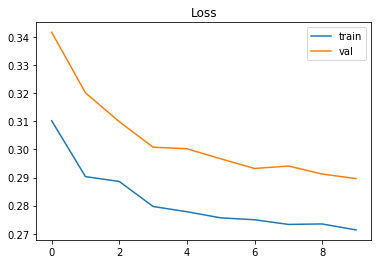

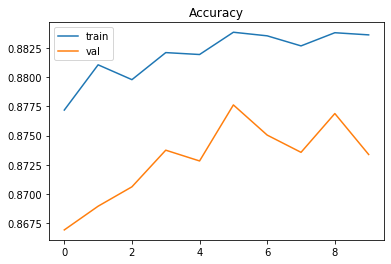

In [25]:
# Loss curve
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.legend(['train', 'val'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.legend(['train', 'val'])
plt.savefig('acc.png')
plt.show()

In [26]:
# Predict testdata
w = np.load('weight_hw2.npy')

# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logigstic'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))
        
# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019252
 Spouse of householder -1.6254039587051394
 Other Rel <18 never married RP of subfamily -1.41957597757654
 Child 18+ ever marr Not in a subfamily -1.2958572076664725
 Unemployed full-time 1.1712558285885908
 Other Rel <18 ever marr RP of subfamily -1.1677918072962366
 Italy -1.0934581438006181
 Vietnam -1.0630365633146415
num persons worked for employer 0.9389922773566495
 1 0.8226614922117184


In [33]:
# Generative model的二元分类

"""
数据预处理与正规化
"""
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train=True)
X_test, _, _ = _normalize(X_test, train=False, specified_column=None, X_mean=X_mean, X_std=X_std)

"""
我们需要分别计算两个类别内的数据平均值𝝁1，𝝁2与协方差矩阵𝜮1，𝜮2。Classfication ppt15页
"""

# Compute in-class mean
# 分别将数据中的两个类别的数据分开，这样才可以计算两个类别的数据平均值𝝁1，𝝁2
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])  # 训练集中属于类别0的数据
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])  # 训练集中属于类别1的数据

mean_0 = np.mean(X_train_0, axis=0)  # 𝝁1
mean_1 = np.mean(X_train_1, axis=0)  # 𝝁2

# Compute in-class covariance
# 计算协方差矩阵𝜮1，𝜮2
# 先用0初始化数组
cov_0 = np.zeros((data_dim, data_dim))  # 𝜮1
cov_1 = np.zeros((data_dim, data_dim))  # 𝜮2

# 公式可看https://blog.csdn.net/mr_hhh/article/details/78490576
for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# print(cov_0)
# print(cov_1)

# Shared covariance is taken as a weighted average of individual in-class covariance.
# 为了减少参数的个数，采用同样的𝜮使其在两个类别上通用。  Classfication ppt22页，公式是23页
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])
# print(cov)

# 有了数据平均值和协方差矩阵，可以直接将唯一的权重矩阵与偏差向量计算出来 Classfication ppt33页
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
# 计算出协方差矩阵的逆，用inv表示
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)
#
# # Directly compute weights and bias  公式在33页
w = np.dot(inv, mean_0 - mean_1)
b = (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1)) + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0])

np.save('weight_hw2_generative.npy', w)  # 将参数保存下来


w = np.load('weight_hw2_generative.npy')  # 加载参数
# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train))) #0.8735

# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

Training accuracy: 0.8747051017398997
 Agriculture 7.5625
 41 -7.53125
 Retail trade 6.90625
 Forestry and fisheries 6.09375
 29 -5.96875
 35 5.26953125
 34 -5.1865234375
 Sales -5.1484375
 Construction -5.13671875
 37 -4.826171875
